In [ ]:
# r13 = 10
# r22 = 6.8
# r33 = 32.2
# r51 = 32.0

# r_voigt = np.array([
#     [0,    0,    0,     0,   r13, 0],
#     [0,    0,    0,    r13,   0,  0],
#     [r33, r33, r33,     0,   0,   0]
# ])

# r_voigt *= 1e-12

# # Refractive index (assuming uniaxial crystal)
# n0 = 2.2

In [1]:
from mpi4py import MPI
from petsc4py.PETSc import ScalarType  # type: ignore
import numpy as np

import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from ufl import ds, dx, grad, inner

In [2]:
msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, 0.0), (2.0, 1.0)), n=(32, 16),
                            cell_type=mesh.CellType.triangle)
V = fem.functionspace(msh, ("Lagrange", 1))


In [3]:
facets = mesh.locate_entities_boundary(msh, dim=(msh.topology.dim - 1),
                                       marker=lambda x: np.logical_or(np.isclose(x[0], 0.0),
                                                                      np.isclose(x[0], 2.0)))

In [4]:
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)

In [5]:
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

In [6]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)
f = 10 * ufl.exp(-((x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2) / 0.02)
g = ufl.sin(5 * x[0])
a = inner(grad(u), grad(v)) * dx
L = inner(f, v) * dx + inner(g, v) * ds

### Variational Formulation for a 2D Poisson Problem

This block defines the weak form of a 2D Poisson equation with a source term `f` inside the domain and a Neumann boundary condition `g` on the boundary.

- `u = ufl.TrialFunction(V)`:  
  Declares `u` as the *trial function*, representing the unknown solution we want to solve for.

- `v = ufl.TestFunction(V)`:  
  Declares `v` as the *test function*, used to build the weak form by multiplying the PDE and integrating.

- `x = ufl.SpatialCoordinate(msh)`:  
  Gets the spatial coordinates `(x[0], x[1])` from the mesh `msh`. These are used to define spatially varying expressions.

- `f = 10 * ufl.exp(-((x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2) / 0.02)`:  
  Defines a **Gaussian source term** centered at (0.5, 0.5), modeling a localized input or heat source in the domain.

  **RHS** $$10*e^{-((x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2) / 0.02}$$

- `g = ufl.sin(5 * x[0])`:  
  Defines a **Neumann boundary condition** (flux) that varies sinusoidally along the x-direction.

- `a = inner(grad(u), grad(v)) * dx`:  
  The **bilinear form**, representing the left-hand side of the weak form:  
  $$a(u, v) = \int_\Omega \nabla u \cdot \nabla v \, dx$$  
  This corresponds to the Laplacian operator \( -\Delta u \) in the strong form.

- `L = inner(f, v) * dx + inner(g, v) * ds`:  
  The **linear form**, i.e., the right-hand side of the weak form:  
  $$L(v) = \int_\Omega f v \, dx + \int_{\partial \Omega} g v \, ds$$ 
  It includes the source term in the domain and the Neumann condition on the boundary.

Together, `a` and `L` define the variational problem:  
**Find** \( u \in V \) such that  
\[
a(u, v) = L(v) \quad \forall v \in V
\]


In [7]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [8]:
with io.XDMFFile(msh.comm, "out_poisson/poisson.xdmf", "w") as file:
    file.write_mesh(msh)
    file.write_function(uh)

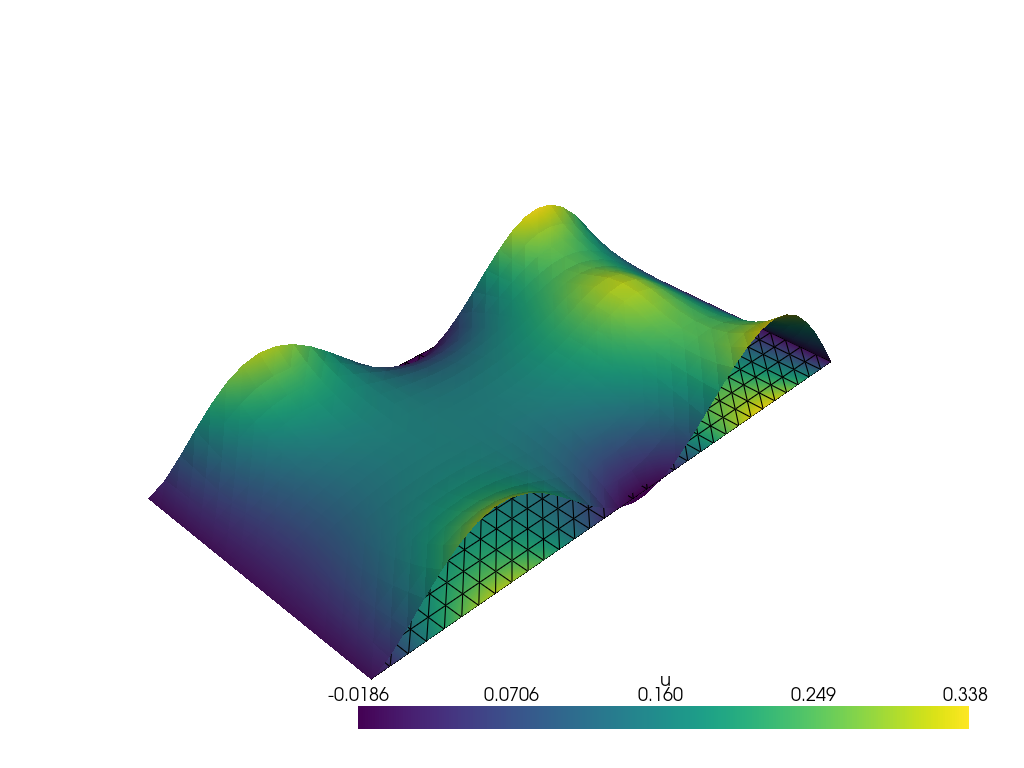

In [9]:
try:
    import pyvista
    cells, types, x = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = uh.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")

In [23]:
-ufl.grad(uh)  # This is the electric field, E, in the context of electrostatics

ComponentTensor(Product(IntValue(-1), Indexed(Grad(Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 0)), MultiIndex((Index(10),)))), MultiIndex((Index(10),)))

In [25]:
# Method 1: Convert to Function using interpolation (fastest)
E_expr = -ufl.grad(uh)
mesh = uh.function_space.mesh
gdim = mesh.geometry.dim
V_vector = fem.functionspace(mesh, ("Lagrange", 1, (gdim,)))
E = fem.Function(V_vector)
E.interpolate(fem.Expression(E_expr, V_vector.element.interpolation_points()))

# Now E contains your electric field values
print(f"Electric field function: {E}")

Electric field function: f


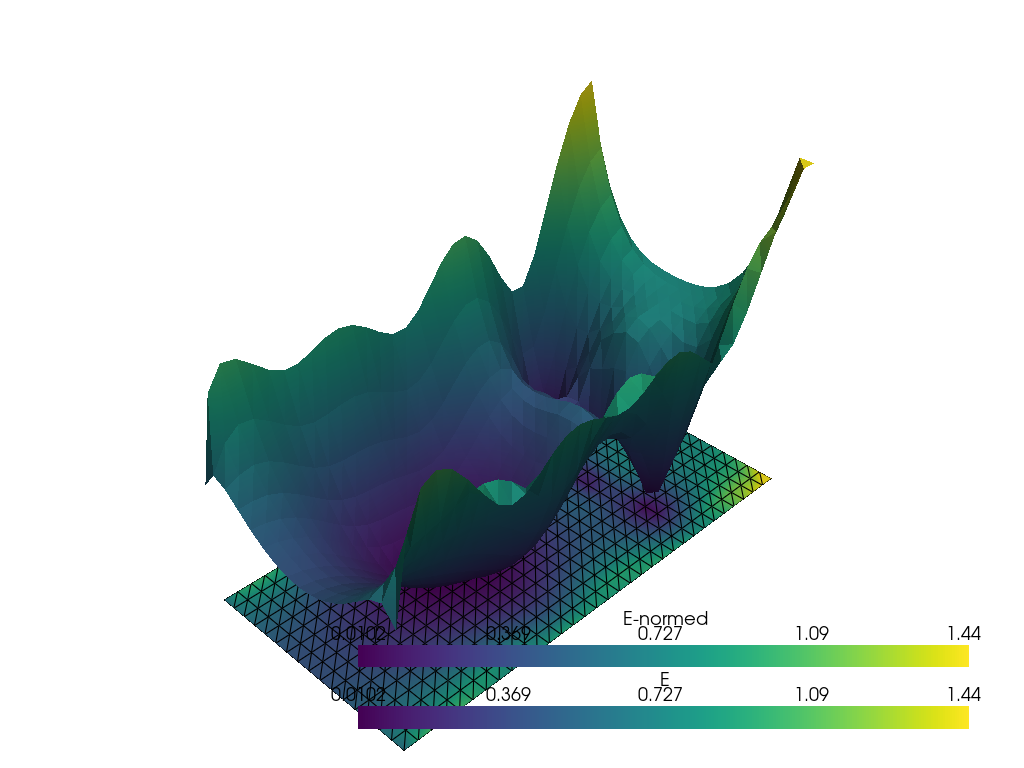

In [40]:
try:
    import pyvista
    cells, types, x = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    # Reshape E to (n_points, gdim) for vector field visualization
    grid.point_data["E"] = E.x.array.real.reshape((x.shape[0], gdim))

    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("E_poisson.png")
    else:
        plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")

In [36]:
E

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,))), 7)

In [37]:
uh

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 0)